# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение, количество детей и уровень дохода клиента, а также цель кредита на факт погашения в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга**.

План работы:
1) Загрузить и изучить данные
2) Провести предобработку данных (обработка пропусков, аномалий, дубликатов)
3) Исследовать данные и проанализировать, есть ли зависимость между следующими параметрами и возвратом кредита в срок:
     - количество детей
     - семейное положение
     - уровень дохода
     - цель кредита

### Шаг 1. Изучение файла с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymystem3 import Mystem

#код для вывода нескольких значений в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# скрываем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Также выведем первые 10 строк датафрейма для наглядного ознакомления с их содержанием.

In [3]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


В таблице 12 столбцов. Тип данных во всех столбцах — object.

Согласно документации к данным:

* `children` — количество детей в семье;
* `days_employed` — общий трудовой стаж в днях;
* `dob_years` — возраст клиента в годах;
* `education` — уровень образования клиента;
* `education_id` — идентификатор уровня образования;
* `family_status` — семейное положение;
* `family_status_id` — идентификатор семейного положения;
* `gender` — пол клиента;
* `income_type` — тип занятости;
* `debt` — имел ли задолженность по возврату кредитов;
* `total_income` — ежемесячный доход;
* `purpose` — цель получения кредита.

**Вывод**

В названиях столбцов проблем нет. Однако встречаются пропуски в данных (столбцы `days_employed` и `total_income`). Исходя из того, что в этих столбцах одинаковое количество пропусков, возможно они относятся к безработным заемщикам. Мы проверим эту гипотезу далее на основе данных столбца `income_type`.

Также из потенциальных проблем мы видим следующие:
* отрицательные и слишком большие значения в столбце `days_employed`, также в этом столбце значения имеют тип `float64`, хотя количество дней может быть только целочисленным. Однако данный столбец нам не понадобится для анализа, поэтому ограничимся изменением формата данных;
* данные об образовании - `education` -  записаны в разных регистрах;
* значения цели кредита - `purpose` - не стандартизованы.


## Шаг 2. Предобработка данных

### Обработка пропусков

In [4]:
df.isna().sum() #выводим суммы пропущенных значений по столбцам

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Убедимся, что в столбцах `days_employed` и `total_income` значения пропущены в одинаковых строках.

In [5]:
df_days_employed_na = df[df['days_employed'].isna() == True]
df_days_employed_na_total_income_na = df_days_employed_na['total_income'].isna().sum()
print(f'Число пропущенных значений в столбце "total_income" в датафрейме с нулевыми значениями по столбцу "days_employed" {df_days_employed_na_total_income_na}')

Число пропущенных значений в столбце "total_income" в датафрейме с нулевыми значениями по столбцу "days_employed" 2174


Проверим гипотезу о том, что пропущенные значения в количестве дней трудового стажа и дохода отражены по безработным заемщикам. Для этого посмотрим первые значения датафрейма с пропущенными значениями.

In [6]:
df_days_employed_na.groupby('income_type')['income_type'].count()

income_type
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
Name: income_type, dtype: int64

**Вывод**

Наша гипотеза не подвердилась. 
Можно предположить, что пропуски являются полностью случайными (MCAR), то есть не зависят от значения других столбцов.
Строки с пропущенными значениями составляют приблизительно 10% от общего количества строк, что достаточно много. 

Наиболее адекватной альтернативой удалению пропущенных значений является их замена медианными значениями дохода в зависимости от его категории. Однако это может исказить результаты исследования, поэтому мы исключим строки с пропущенными значениями для проверки гипотезы о зависимости дохода и вероятности возврата кредита.


Вместе с тем стоит обратить внимание кредитного отдела на данные пропуски. Они наиболее вероятно связаны с неполнотой базы данных либо ошибкой при выгрузке, т. к. данная информация является обязательной при предоставлении кредита.

Заменим пропущенные значения в столбце `days_employed` на 0, столбца `total_income` на -1, чтобы в дальнейшим удалить строки с пропущенными значениями в `total_income` из анализа зависимости дохода и вероятности возврата кредита.

In [7]:
df['days_employed'] = df['days_employed'].fillna(0)
df['total_income'] = df['total_income'].fillna(-1)

df.isna().sum() #убеждаемся, что пропущенные значения отсутствуют

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Убедимся, что все значения "0" в столбце `total_income` являются заполненными пропусками в данных, для того чтобы мы могли отбросить строки с этими значениями при анализе параметров, не зависящих от дохода.

In [8]:
df[df['total_income'] == 0]['total_income'].count()

0

### Замена типов данных

В столбце `days_employed` встречаются отрицательные и слишком большие значения. Кроме того, данные представлены в формате вещественных чисел. Для начала переведем данные в целочисленный формат, для этого используем метод `astype`.

In [9]:
try:
    df['days_employed'] = df['days_employed'].astype(int)
except:
    print('Ошибка')

Далее проанализируем распределение значений с помощью гистограммы:

<AxesSubplot:xlabel='days_employed'>

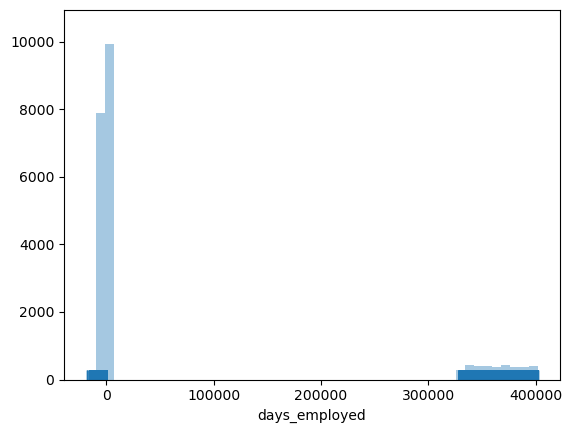

In [10]:
%matplotlib inline
sns.distplot(a=df["days_employed"], hist=True, kde=False, rug=True, axlabel='days_employed')

Мы видим большой отрыв группы значений от основной массы. Разделим данные значения на 1000.

In [11]:
#значения больше 10 000 делим на 1000
df.loc[df['days_employed'] > 100000, 'days_employed'] = df.loc[df['days_employed'] > 100000, 'days_employed']/1000

<AxesSubplot:xlabel='days_employed'>

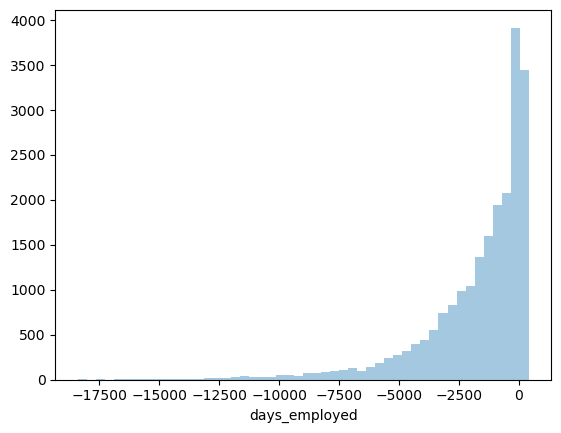

In [12]:
sns.distplot(a=df["days_employed"], hist=True, kde=False, rug=False)

Избавимся от отрицательных значений.

In [13]:
df['days_employed'] = df['days_employed'].abs()

Посмотрим информацию об обновленных данных.

<AxesSubplot:xlabel='days_employed'>

16335    18388.0
4299     17615.0
7329     16593.0
17838    16264.0
16825    16119.0
3974     15835.0
1539     15785.0
4321     15773.0
7731     15618.0
15675    15410.0
Name: days_employed, dtype: float64

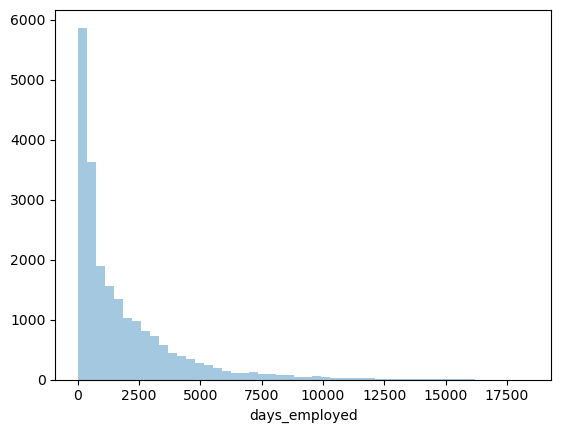

In [14]:
sns.distplot( a=df["days_employed"], hist=True, kde=False, rug=False)
df['days_employed'].sort_values(ascending=False).head(10)

Распределение стало более правдоподобным, однако по-прежнему присутствует достаточно много очень больших значений. С учетом того, что данный столбец не будет в дальнейшем использоваться в анализе, мы можем оставить данные в таком виде.

Также переведем данные в столбце `total_income` в формат int.

In [15]:
df['total_income'] = df['total_income'].astype('int')
df['total_income'].head(10)

0    253875
1    112080
2    145885
3    267628
4    158616
5    255763
6    240525
7    135823
8     95856
9    144425
Name: total_income, dtype: int64

Заменим значения "0" и "1" в столбце `debt` на значения типа bool.

In [16]:
df['debt'].value_counts() #вывод значений для последующей проверки

df.loc[df['debt'] == 1, 'debt'] = True
df.loc[df['debt'] == 0, 'debt'] = False

df['debt'].value_counts()

debt
0    19784
1     1741
Name: count, dtype: int64

debt
False    19784
True      1741
Name: count, dtype: int64

**Вывод**

Мы обработали значения в столбце `days_employed`. Мы произвели следующие операции:

* Привели значения к целочисленному формату для корректного отражения количества дней
* Обработали группу аномально выделяющихся значений, поделив их на 1000
* Избавились от отрицательных значений, применив функцию модуля

С учетом того, что данные из столбца не являются необходимыми для целей данного анализа, работа по их обработке завершена.

### Обработка дубликатов

Для поиска неявных дубликатов посмотрим на распределение значений в необходимых для анализа столбцах:

In [17]:
full_duplicates_number = df.duplicated().sum() #выявляем число полных дубликатов
print(f'Число полных дубликатов: {full_duplicates_number}')

Число полных дубликатов: 54


In [18]:
for column in ['children', 'dob_years', 'education', 'family_status', 'income_type', 'purpose']:
    print(df[column].value_counts())
    print()

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: count, dtype: int64

dob_years
35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
22    183
66    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: count, dtype: int64

education
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Н

В столбце `education` присутствуют неявные повторы, связанные с регистром. Приведем все значения к нижнему регистру.

In [19]:
df['education'] = df['education'].str.lower()

Проверим получившийся результат:

In [20]:
df['education'].value_counts()

education
среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: count, dtype: int64

В столбце `children` наблюдаем аномальные данные:
* большое количество записей с 20 детьми, при том, что в остальных записях количество детей не превышает 5;
* наличие значений -1.

Предположим, что данные искажения связаны с опечатками, и "20" должно означать "2", а "-1" - "1".
Заменим значения на указанные.

In [21]:
df.loc[df['children'] == 20, 'children'] = 2
df.loc[df['children'] == -1, 'children'] = 1

Проверим результат:

In [22]:
 df['children'].value_counts()

children
0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: count, dtype: int64

Теперь займемся полными дубликатами.

In [23]:
full_duplicates_number = df.duplicated().sum() #выявляем число полных дубликатов
print(f'Число полных дубликатов: {full_duplicates_number}')

Число полных дубликатов: 71


С учетом большого количества данных, в том числе высокодисперсных, содержащихся в одной строке, можем сделать вывод, что выявленные дубликаты действительно являются ошибками, а не одинаковыми данными по разным кредитам.

In [24]:
df = df.drop_duplicates().reset_index(drop=True) #удаляем полные дубликаты

In [25]:
full_duplicates_number = df.duplicated().sum()
print(f'Число полных дубликатов после удаления: {full_duplicates_number}') #убеждаемся, что все полные дубликаты удалены

Число полных дубликатов после удаления: 0


**Вывод**

Мы обнаружили два типа повторов: явные и неявные. Проблему с явными повторами мы решили, удалив дублирующиеся строки.


Неявные повторы обнаружены нами в столбцах `education`, `purpose` и `children`. Значения в столбце `education` мы поправили, приведя их к нижнему регистру. Значения в столбце `children` заменили на значения, которые наиболее вероятно имелись в виду при заполнении. Проблему со значениями в столбце `purpose` мы решим с помощью лемматизации.

Т. к. данные столбцов заполняются сотрудниками фронт-офиса на основе предоставленных документов при обработке заявки от клиента, необходимо оптимизировать данный процесс, введя требование для сотрудников указывать значения в данных столбцах в рамках заранее установленных значений (например, введя ограничения в системе на доступные для выбора варианты) вместо ручного ввода. Это поможет структурировать данные и избежать путаницы.

### Лемматизация

Для начала определим итоговые цели кредита, по которым мы хотим разделить имеющиеся данные:

In [26]:
m = Mystem()

In [27]:
#объединяем в одну строку список значений столбца purpose и лемматизируем их
purpose_lemmatized = m.lemmatize(','.join(df['purpose']))

#выводим самые часто встречающиеся слова
from collections import Counter
Counter(purpose_lemmatized).most_common()

[(' ', 33570),
 (',', 21453),
 ('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('подержать', 853),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('приобретение', 461),
 ('профильный', 436),
 ('подержанный', 111),
 ('\n', 1)]

Таким образом мы можем выделить следующие основные типы кредитов:
* ипотека
* автокредиты
* на образование
* на свадьбу

Для присвоения данных значений строкам напишем функцию, которая будет принимать значение столбца `purpose` и с помощью лемматизации возвращать один из видов кредитов, определенных выше.

In [28]:
def loan_type(purpose):
        lemma = m.lemmatize(purpose)
        if 'недвижимость' in lemma or 'жилье' in lemma:
            return 'ипотека'
        elif 'автомобиль' in lemma:
            return 'автокредит'
        elif 'образование' in lemma:
            return 'на образование'
        elif 'свадьба'in lemma:
            return 'на свадьбу'

In [29]:
df['purpose_type'] = df['purpose'].apply(loan_type) #применим функцию к столбцу с целью кредита
df.head(10) #выведем первые 10 строк датафрейма для проверки

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_type
0,1,8437.000,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,ипотека
1,1,4024.000,36,среднее,1,женат / замужем,0,F,сотрудник,False,112080,приобретение автомобиля,автокредит
2,0,5623.000,33,среднее,1,женат / замужем,0,M,сотрудник,False,145885,покупка жилья,ипотека
3,3,4124.000,32,среднее,1,женат / замужем,0,M,сотрудник,False,267628,дополнительное образование,на образование
4,0,340.266,53,среднее,1,гражданский брак,1,F,пенсионер,False,158616,сыграть свадьбу,на свадьбу
5,0,926.000,27,высшее,0,гражданский брак,1,M,компаньон,False,255763,покупка жилья,ипотека
6,0,2879.000,43,высшее,0,женат / замужем,0,F,компаньон,False,240525,операции с жильем,ипотека
7,0,152.000,50,среднее,1,женат / замужем,0,M,сотрудник,False,135823,образование,на образование
8,2,6929.000,35,высшее,0,гражданский брак,1,F,сотрудник,False,95856,на проведение свадьбы,на свадьбу
9,0,2188.000,41,среднее,1,женат / замужем,0,M,сотрудник,False,144425,покупка жилья для семьи,ипотека


Убедимся, что количество значений в новом столбце равно общему количеству строк для проверки того, что мы покрыли все строки при присвоении типа кредита:

In [30]:
if df['purpose_type'].count() == df['purpose'].count():
    print("Количество равно, ошибок нет")
else:
    print("Ошибка")

Количество равно, ошибок нет


### Категоризация данных

Для дальнейшего анализа нам необходимо категоризировать данные в следующих столбцах:
* `children`
* `total_income`

#### Количество детей

Начнем с `children`. Разделим значения на следующие категории:

* клиенты без детей
* клиенты с 1-2 детьми
* многодетные клиенты (3 и более детей)

In [31]:
#создадим словарь
children_category_dict = pd.DataFrame(columns=['children_category', 'children_category_id'],
                                     data=[
                                         ["бездетные", 0],
                                         ["с 1-2 детьми", 1],
                                         ["многодетные", 2]
                                     ])
#и выведем его на экран
children_category_dict

,children_category,children_category_id
0,бездетные,0
1,с 1-2 детьми,1
2,многодетные,2


Напишем функцию для категоризации клиентов по количеству детей:

In [32]:
def children_category(children):
    if children == 0:
        return 0
    elif 0 < children < 3:
        return 1
    elif 3 <= children:
        return 2

In [33]:
#применим функцию к столбцу children
df['children_category_id'] = df['children'].apply(children_category) 
df.head() #проверим результаты

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_type,children_category_id
0,1,8437.000,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,ипотека,1
1,1,4024.000,36,среднее,1,женат / замужем,0,F,сотрудник,False,112080,приобретение автомобиля,автокредит,1
2,0,5623.000,33,среднее,1,женат / замужем,0,M,сотрудник,False,145885,покупка жилья,ипотека,0
3,3,4124.000,32,среднее,1,женат / замужем,0,M,сотрудник,False,267628,дополнительное образование,на образование,2
4,0,340.266,53,среднее,1,гражданский брак,1,F,пенсионер,False,158616,сыграть свадьбу,на свадьбу,0


Выведем частоту распределения по категориям:

In [34]:
df['children_category_id'].value_counts()

children_category_id
0    14091
1     6983
2      380
Name: count, dtype: int64

Далее категоризируем значения столбца `total_income`.
Для начала посмотрим на распределение значений:

<AxesSubplot:xlabel='total_income'>

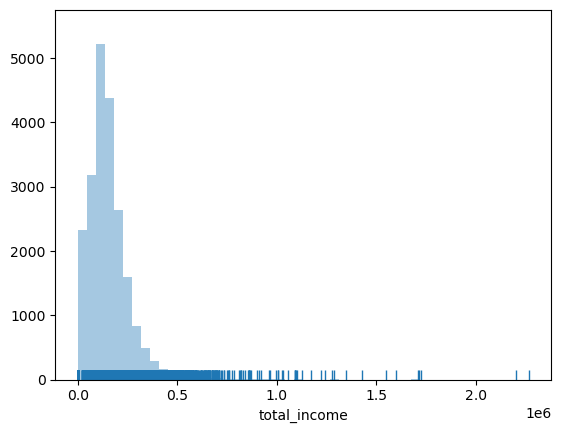

In [35]:
sns.distplot( a=df["total_income"], hist=True, kde=False, rug=True)

In [36]:
#выведем топ значений по столбцу
df["total_income"].sort_values(ascending=False).head()

12390    2265604
19548    2200852
9159     1726276
20742    1715018
17137    1711309
Name: total_income, dtype: int64

Т. к. экстремальные значения единичны, такое распределение выглядит правдоподобным, с данными можно работать.

In [37]:
#посчитаем медиану и среднее
df["total_income"].median()
df["total_income"].mean()

135781.0

151010.40281532583

Для категоризации данных корректнее использовать медиану, т. к. она не подвержена влиянию аномально высоких значений.

Выделим следующие категории заемщиков:
* **низкий уровень дохода** (ниже половины медианы включительно)
* **уровень дохода ниже среднего** (от половины медианы до медианы включительно)
* **уровень дохода выше среднего** (от медианы до 2 медиан включительно)
* **высокий уровень дохода** (выше двух медиан)

In [38]:
#создадим словарь
total_income_category_dict = pd.DataFrame(columns=[
    'total_income_category', 'total_income_category_id'],
                                     data=[
                                         ["низкий", 0],
                                         ["ниже среднего", 1],
                                         ["выше среднего", 2],
                                         ["высокий", 3]
                                     ])
#и выведем его на экран
total_income_category_dict

,total_income_category,total_income_category_id
0,низкий,0
1,ниже среднего,1
2,выше среднего,2
3,высокий,3


Напишем функцию для категоризации:

In [39]:
median = df["total_income"].median() #сохраним в переменную значение медианы столбца total_income

def total_income_category(total_income):
    if total_income <= (median / 2):
        return 0
    elif (median / 2) < total_income <= median:
        return 1
    elif median < total_income <= (median * 2):
        return 2
    elif (median * 2) < total_income:
        return 3

In [40]:
#применим формулу к столбцу total_income
df['total_income_category_id'] = df['total_income'].apply(total_income_category)

#проверим получившийся результат
df.head(10)

#также убедимся в корректном распределении "низкой" и "высокой" категорий:
df[df['total_income'] < (median / 2)]['total_income_category_id'].value_counts()
df[df['total_income'] > (median * 2)]['total_income_category_id'].value_counts()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_type,children_category_id,total_income_category_id
0,1,8437.000,42,высшее,0,женат / замужем,0,F,сотрудник,False,253875,покупка жилья,ипотека,1,2
1,1,4024.000,36,среднее,1,женат / замужем,0,F,сотрудник,False,112080,приобретение автомобиля,автокредит,1,1
2,0,5623.000,33,среднее,1,женат / замужем,0,M,сотрудник,False,145885,покупка жилья,ипотека,0,2
3,3,4124.000,32,среднее,1,женат / замужем,0,M,сотрудник,False,267628,дополнительное образование,на образование,2,2
4,0,340.266,53,среднее,1,гражданский брак,1,F,пенсионер,False,158616,сыграть свадьбу,на свадьбу,0,2
5,0,926.000,27,высшее,0,гражданский брак,1,M,компаньон,False,255763,покупка жилья,ипотека,0,2
6,0,2879.000,43,высшее,0,женат / замужем,0,F,компаньон,False,240525,операции с жильем,ипотека,0,2
7,0,152.000,50,среднее,1,женат / замужем,0,M,сотрудник,False,135823,образование,на образование,0,2
8,2,6929.000,35,высшее,0,гражданский брак,1,F,сотрудник,False,95856,на проведение свадьбы,на свадьбу,1,1
9,0,2188.000,41,среднее,1,женат / замужем,0,M,сотрудник,False,144425,покупка жилья для семьи,ипотека,0,2


total_income_category_id
0    3432
Name: count, dtype: int64

total_income_category_id
3    2105
Name: count, dtype: int64

In [41]:
#посмотрим распределение по категориям
df['total_income_category_id'].value_counts()

total_income_category_id
2    8622
1    7295
0    3432
3    2105
Name: count, dtype: int64

In [42]:
#сверим общее количество распределенных значений

if df['total_income_category_id'].value_counts().sum() == len(df['total_income_category_id']):
    print('Количество распределенных значений совпадает с общим количеством, ошибок нет')
else:
    print('ошибка')

Количество распределенных значений совпадает с общим количеством, ошибок нет


Выведем данные в столбцах `education` и `family_status` в словари.

In [43]:
education_dict = df[['education','education_id']]
#удалим дубликаты
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
#выведем словарь
education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [44]:
family_status_dict = df[['family_status', 'family_status_id']]
#удалим дубликаты
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
#выведем словарь
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


In [45]:
#создадим датафрейм со столбцами, необходимыми для дальнейшего анализа
data = df[['family_status_id', 'debt', 'purpose_type', 'children_category_id',
       'total_income_category_id']]
data.head()

,family_status_id,debt,purpose_type,children_category_id,total_income_category_id
0,0,False,ипотека,1,2
1,0,False,автокредит,1,1
2,0,False,ипотека,0,2
3,0,False,на образование,2,2
4,1,False,на свадьбу,0,2


**Вывод**

Мы категоризировали данные в столбцах `children` и `total_income` для удобства дальнейшего анализа и присвоили каждой категории идентификатор.
Данные о соответствии категорий и идентификаторов мы вывели в отдельные словари (`children_category_dict` и `total_income_category_dict`).

Также мы выделили отдельные словари для столбцов `education` и `family_status` и их идентификаторов (`education_dict` и `family_status_dict`).

## Шаг 3. Выявление зависимостей

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для дальнейшего анализа нам потребуется столбец `debt`. Убедимся, что он содержит только значения "0" и "1".

In [46]:
data['debt'].value_counts()

debt
False    19713
True      1741
Name: count, dtype: int64

In [47]:
#построим сводную таблицу по столбцам 'children_category_id' и 'debt'.
pivot_children = data.pivot_table(
    index='children_category_id',
    columns='debt',
    values='family_status_id', #произвольный столбец
    aggfunc='count')

#добавим столбец с долей заемщиков, имевших задолженность
pivot_children['debt_percentage'] = pivot_children[True] / (pivot_children[True] + pivot_children[False])

children_category_dict #выведем на экран словарь


#отсортируем сводную таблицу по возрастанию столбца debt_percentage
pivot_children = pivot_children.sort_values(by='debt_percentage')

#отформатируем значения столбца debt_percentage для отображения в процентах
pivot_children_stylized = pivot_children.style.format({'debt_percentage': '{:.1%}'})

pivot_children_stylized #выведем сводную таблицу на экран

,children_category,children_category_id
0,бездетные,0
1,с 1-2 детьми,1
2,многодетные,2


debt,False,True,debt_percentage
children_category_id,,,
0,13028,1063,7.5%
2,349,31,8.2%
1,6336,647,9.3%


In [48]:
#попробуем объединить заемщиков категорий 1 и 2 и рассчитать для них долю невозвратов
print(
    f'''{(pivot_children.loc[1, 1] + pivot_children.loc[2, 1]) / (
    (pivot_children.loc[1, 1] + pivot_children.loc[2, 1]) + 
    (pivot_children.loc[1, 0] + pivot_children.loc[2, 0])
):.1%}'''
)

9.2%


Доля невозвратов несущественно изменилась при объединении категорий заемщиков с 1-2 и 3 и более детьми. С учетом небольшого количества записей в категории 2 для вывода мы можем использовать объединенные значения.

**Вывод**

Доля заемщиков, имевших задолженность, у которых есть дети (категория 1 + 2) составляет 9.2%, в то время как доля таких заемщиков без детей (категория 0) ниже, и составляет 7.5%.

Таким образом мы можем сделать вывод, что вероятность возврата кредита заемщиком, не имеющим детей, выше, чем заемщиком, имеющим детей.

___

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [49]:
#построим сводную таблицу по столбцам 'family_status_id' и 'debt'.
pivot_family_status = data.pivot_table(
    index='family_status_id',
    columns='debt',
    values='children_category_id', #произвольный столбец
    aggfunc='count')

#добавим столбец с долей заемщиков, имевших задолженность
pivot_family_status['debt_percentage'] = pivot_family_status[True] / (
    pivot_family_status[True] + pivot_family_status[False]
)

family_status_dict #выведем на экран словарь

#отсортируем сводную таблицу по возрастанию столбца debt_percentage
pivot_family_status = pivot_family_status.sort_values(by='debt_percentage')

#отформатируем значения столбца debt_percentage для отображения в процентах
pivot_family_status = pivot_family_status.style.format({'debt_percentage': "{:.1%}"})

pivot_family_status #выведем сводную таблицу на экран

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


debt,False,True,debt_percentage
family_status_id,,,
2,896,63,6.6%
3,1110,85,7.1%
0,11408,931,7.5%
1,3763,388,9.3%
4,2536,274,9.8%


**Вывод**

Наименьшее количество задолженностей по кредитам встречается у вдов / вдовцов и людей в разводе.
Далее следуют женатые люди.
Существенное увеличение количества задолженностей встречается у людей в гражданском браке и неженатых людей.

___

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для анализа уровня дохода отфильтруем в датафрейме строки только с заполненными значениями дохода.

In [50]:
df_income = df[df['total_income'] != -1]
data_income = df_income[['family_status_id', 'debt', 'purpose_type', 'children_category_id',
       'total_income_category_id']].reset_index(drop=True)
data_income.head()

,family_status_id,debt,purpose_type,children_category_id,total_income_category_id
0,0,False,ипотека,1,2
1,0,False,автокредит,1,1
2,0,False,ипотека,0,2
3,0,False,на образование,2,2
4,1,False,на свадьбу,0,2


In [51]:
#построим сводную таблицу по столбцам 'total_income_category_id' и 'debt'.
pivot_total_income = data_income.pivot_table(
    index='total_income_category_id',
    columns='debt',
    values='children_category_id', #произвольный столбец
    aggfunc='count')

#добавим столбец с долей заемщиков, имевших задолженность
pivot_total_income['debt_percentage'] = pivot_total_income[True] / (
    pivot_total_income[True] + pivot_total_income[False]
)

total_income_category_dict #выведем на экран словарь

#отсортируем сводную таблицу по возрастанию столбца debt_percentage
pivot_total_income = pivot_total_income.sort_values(by='debt_percentage') 

#отформатируем значения столбца debt_percentage для отображения в процентах
pivot_total_income = pivot_total_income.style.format({'debt_percentage': '{:.1%}'})

pivot_total_income #выведем сводную таблицу на экран

,total_income_category,total_income_category_id
0,низкий,0
1,ниже среднего,1
2,выше среднего,2
3,высокий,3


debt,False,True,debt_percentage
total_income_category_id,,,
0,1236,93,7.0%
3,1956,149,7.1%
2,7907,715,8.3%
1,6681,614,8.4%


**Вывод**

Наименьший уровень возврата среди заемщиков с доходами категорий "ниже среднего" и "выше среднего", т. е. от половины до двух медиан.
Уровень возвратов среди категории заемщиков с высоким и низким уровнем дохода практически одинаковый (около 93%).

___

- Как разные цели кредита влияют на его возврат в срок?

In [52]:
#построим сводную таблицу по столбцам 'purpose_type' и 'debt'.
pivot_purpose = data.pivot_table(
    index='purpose_type',
    columns='debt',
    values='children_category_id', #произвольный столбец
    aggfunc='count')

#добавим столбец с долей заемщиков, имевших задолженность
pivot_purpose['debt_percentage'] = pivot_purpose[True] / (
    pivot_purpose[True] + pivot_purpose[False]
)

#отсортируем сводную таблицу по возрастанию столбца debt_percentage
pivot_purpose = pivot_purpose.sort_values(by='debt_percentage')

#отформатируем значения столбца debt_percentage для отображения в процентах
pivot_purpose = pivot_purpose.style.format({'debt_percentage': '{:.1%}'})

#выведем сводную таблицу на экран
pivot_purpose

debt,False,True,debt_percentage
purpose_type,,,
ипотека,10029,782,7.2%
на свадьбу,2138,186,8.0%
на образование,3643,370,9.2%
автокредит,3903,403,9.4%


**Вывод**

Наиболее низкий уровень задолженности - по ипотечным кредитам, что может объясняться риском потери квартиры в случае невозврата.

Кредиты на покупку автомобиля и на образование обладают наибольшим уровнем невозвратов.

## Шаг 4. Общий вывод

В рамках исследования мы получили неоднозначные выводы.

По **количеству детей**:
Доля заемщиков, имевших задолженность, у которых есть дети составляет 9.2%, в то время как доля таких заемщиков без детей ниже, и составляет 7.5%.

В зависимости от **семейного положения** вероятность возврата кредита распределяется следующим образом:
Наименьшее количество задолженностей по кредитам встречается у вдов / вдовцов и людей в разводе (6.5% и 7.1% соответственно).
Далее следуют женатые люди (7.5%).
Существенное увеличение количества задолженностей встречается у людей в гражданском браке (9.3%) и неженатых людей (9.8%), то есть людей, которые никогда не были женаты.

По **уровню дохода** данные получились следующими:
Наименьший уровень невозврата среди заемщиков с доходами категорий "ниже среднего" (8.4%) и "выше среднего" (8.3%), т. е. от половины до двух медиан.
Уровень невозвратов среди категории заемщиков с высоким и низким уровнем дохода практически одинаковый (около 7%).

По **цели кредита**:
Наиболее низкий уровень задолженности - по ипотечным кредитам (7.2%).

Кредиты на покупку автомобиля и на образование обладают наибольшим уровнем возвратов (7.2%).
Далее следуют кредиты на свадьбу (7.9%) и кредиты на образование (9.2%) и автокредиты (9.4%).